## Data Import

In [1]:
import os

from IPython.core.pylabtools import figsize

from processing.data_processing import *


# define variable names
tia_scales = scales.tia_scales
hcsds_scales = scales.hcsds_scales
ati_scales = scales.ati_scales
manip_check_scales = scales.manip_check_scales

for k in scales.scale_titles:
    scales.scale_titles[k] = scales.scale_titles[k].replace('TiA - ', '')


# Create output and plot directories if they don't exist
plots_path = '../plots/age/univariate_analysis/'
os.makedirs(plots_path, exist_ok=True)

output_path = '../output/age/'
os.makedirs(output_path, exist_ok=True)

# Load data
data = pd.read_csv('../data/data_scales.csv')
print(f"Total sample size: {len(data)}")
print(f"\nGroup distribution:")
print(data['stimulus_group'].value_counts())
print('\n')

# compute basic statistics for later tests
N = len(data)
p = len(tia_scales)
k = data['stimulus_group'].nunique()

# set alpha and power
alpha = 0.05
power = 0.80

print(f'Sample size: N = {N}')
print(f'Number of outcomes: p = {p}')
print(f'Number of groups: k = {k}')



Total sample size: 255

Group distribution:
stimulus_group
1    129
0    126
Name: count, dtype: int64


Sample size: N = 255
Number of outcomes: p = 5
Number of groups: k = 2


## Data Preparation

In [2]:
data = effect_coding(data)

demographics = ['age', 'gender', 'education', 'ai_exp']
continuous_vars = hcsds_scales + ati_scales + ['age', 'page_submit']

demographics_c = [f'{s}_c' for s in demographics]
hcsds_scales_c = [f'{s}_c' for s in hcsds_scales]
ati_scales_c = [f'{s}_c' for s in ati_scales]

print(f"Prepared {len(data)} observations for analysis")
print(f"Continuous moderators: {len(continuous_vars)}")
print(f"Total moderators to test: {len(continuous_vars) + 3}")  # + gender, education, Q19

Prepared 255 observations for analysis
Continuous moderators: 5
Total moderators to test: 8


# Split age groups

In [3]:
SPLIT_AGE = 60

print(f'full sample:\n'
      f'\tmean = {data['age'].mean():.3f}\n'
      f'\tN = {len(data)}\n')

data_young = data[data['age'] < SPLIT_AGE]
data_old = data[data['age'] >= SPLIT_AGE]

print(f'young people (<{SPLIT_AGE}):\n'
      f'\tmean = {data_young['age'].mean():.3f}\n'
      f'\tN = {len(data_young)}\n')
print(f'old people (>={SPLIT_AGE}):\n'
      f'\tmean = {data_old['age'].mean():.3f}\n'
      f'\tN = {len(data_old)}\n')

full sample:
	mean = 27.345
	N = 255

young people (<60):
	mean = 25.091
	N = 242

old people (>=60):
	mean = 69.308
	N = 13



## Looking at age

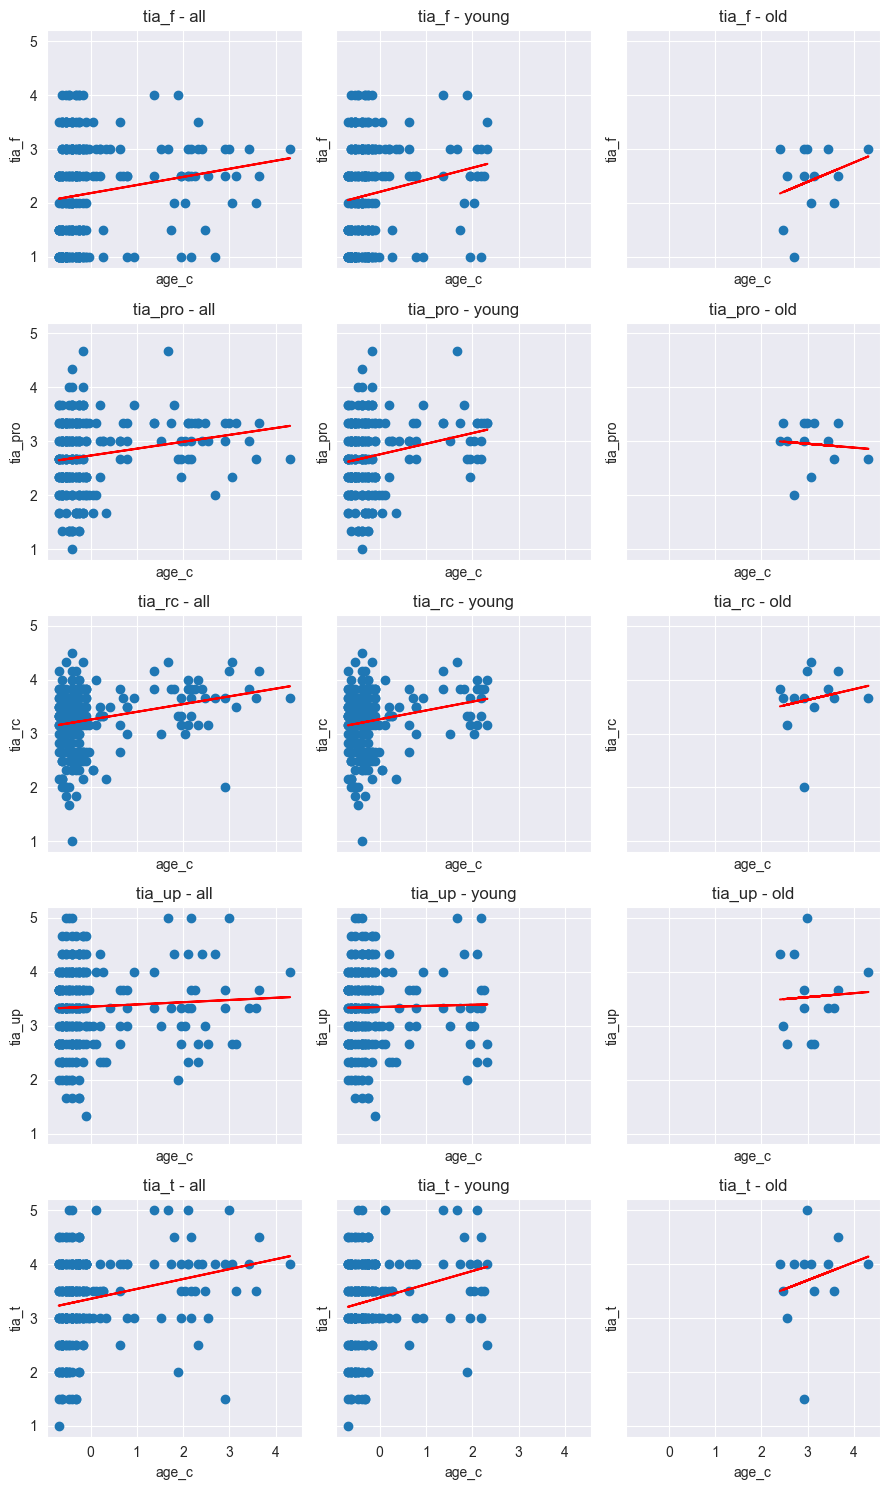

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(9,15), sharex=True, sharey=True)

names = ['all', 'young', 'old']

#HERE

for i, d in enumerate([data, data_young, data_old]):
    for j, tia_scale in enumerate(tia_scales):
        axs[j, i].scatter(d['age_c'], d[tia_scale])

        m, b = np.polyfit(d['age_c'], d[tia_scale], 1)
        axs[j, i].plot(d['age_c'], m*d['age_c']+b, color='red')

        axs[j, i].set_title(f'{tia_scale} - {names[i]}')
        axs[j, i].set_xlabel('age_c')
        axs[j, i].set_ylabel(tia_scale)

plt.tight_layout()
plt.show()

## Build Univariate Linear Regression Models
Use `data_young` only, as sample size of `data_old` is too small.


In [5]:
# define families of effects here to use later for MCP correction
direct_effects = demographics_c + hcsds_scales_c + ati_scales_c
interaction_effects = [f'group_effect:{eff}' for eff in direct_effects]

# build models for each tia_subscale separately
import statsmodels.formula.api as smf

results = {}
for subscale in tia_scales:
    formula = (f'{subscale} ~ group_effect '
               f'+ {' + '.join(direct_effects)}'
               f'+ {' + '.join(interaction_effects)}')

    result = smf.ols(formula, data=data_young).fit()

    print(f'Predicting {subscale}')
    print(result.summary())
    print(f'{'='*78}\n\n')

    results[subscale] = result

Predicting tia_f
                            OLS Regression Results                            
Dep. Variable:                  tia_f   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.447
Date:                Fri, 16 Jan 2026   Prob (F-statistic):            0.00248
Time:                        13:52:16   Log-Likelihood:                -307.17
No. Observations:                 242   AIC:                             646.3
Df Residuals:                     226   BIC:                             702.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Interce

In [6]:
CORRECTION_METHOD = "holm"
################################

model_stats = {}

# save results to tables
for subscale in tia_scales:
    result = results[subscale]

    df = pd.DataFrame(result.summary().tables[1])

    df.iloc[0, 0] = 'effect'
    df.columns = ['effect', 'coef', 'se', 't', 'p', 'CI_lower', 'CI_higher']
    df = df[1:] # drop original header row
    df = df.set_index('effect', drop=True)

    # save to file
    df.to_csv(f'{output_path}{subscale}_regression_coef_YOUNG.csv', index=True)

    # save model stats for later
    model_stats[subscale] = {
        'r_squared': result.rsquared,
        'adj_r_squared': result.rsquared_adj,
        'F': result.fvalue,
        'p_for_F': result.f_pvalue,
        'df_model': result.df_model,
        'df_resid': result.df_resid
    }

model_stats_table = pd.DataFrame(model_stats)
model_stats_table.to_csv(f'{output_path}regression_model_stats_YOUNG.csv', index=True)
print(model_stats_table)

'''
Somehow, the `tables` object from `statsmodels` gives values as a `Cell` object instead of just numbers.
It's easiest to just save everything to a file and then read it again (very stupid, I know).
'''

# correct p-values for multiple comparisons
from statsmodels.stats.multitest import multipletests
from scripts.utils import apa_p

def convert_to_partial_eta_sq(t, df_resid):
    return t**2 / (t**2 + df_resid)


# define families
families = {
    'group': ['group_effect'],
    'direct': direct_effects,
    'interaction': interaction_effects
}

regr_res = {}
for subscale in tia_scales:
    result_df = pd.read_csv(f'{output_path}{subscale}_regression_coef_YOUNG.csv')
    result_df = result_df.set_index('effect')

    p_vals_adj = {}
    for fam in families.values():
        # get all relevant p values
        selection = pd.DataFrame(result_df['p'].loc[fam].copy())

        # convert to adjusted p values
        adjusted = multipletests(selection['p'],
                                 alpha=alpha,
                                 method=CORRECTION_METHOD)[1]
        selection = selection.assign(p_val_adj=adjusted)

        # add to dictionary containing adjusted p-values
        for i, row in selection.iterrows():
            p_vals_adj[i] = row['p_val_adj']

    result_df['p_adj'] = p_vals_adj

    p_adj_report = []
    partial_eta_sq = []
    for i, row in result_df.iterrows():
        p_adj_report.append(apa_p(row['p_adj'],
                                  sig_stars=True))
        partial_eta_sq.append(convert_to_partial_eta_sq(row['t'], model_stats[subscale]['df_resid']))

    result_df['partial_eta_sq'] = partial_eta_sq
    result_df['p_adj_report'] = p_adj_report

    result_df.index = [s[:-2] if s[-2:] == '_c' else s for s in list(result_df.index)]

    # save to file, overwrite original csv file
    result_df.round(decimals=3).to_csv(f'{output_path}{subscale}_regression_coef_YOUNG.csv', index=True)

    # also save to memory
    regr_res[subscale] = result_df

                    tia_f     tia_pro      tia_rc      tia_up         tia_t
r_squared        0.139727    0.166316    0.163424    0.072544  2.300944e-01
adj_r_squared    0.082629    0.110983    0.107899    0.010988  1.789944e-01
F                2.447153    3.005736    2.943250    1.178494  4.502831e+00
p_for_F          0.002480    0.000204    0.000272    0.289662  1.874533e-07
df_model        15.000000   15.000000   15.000000   15.000000  1.500000e+01
df_resid       226.000000  226.000000  226.000000  226.000000  2.260000e+02


### Non-inferiority margins
Don't base margins on MDE this time, but use same values as with *full sample* (hardcode values).

In [7]:
# hardcode non-inferiority margins from full sample MDE
ni_margin = {'tia_f'    : 0.34773256417549586,
             'tia_pro'  : 0.24880864505660477,
             'tia_rc'   : 0.20684092179404495,
             'tia_up'   : 0.2907763683191646,
             'tia_t'    : 0.28178328476290176}


Non-Inferiority Test Results for 'Familiarity':
  Mean difference: M_diff = 0.161, SE = 0.125
  95% CI: [-0.0840, 0.4060]
  SESOI margin: -0.3477
  z = 4.070, p < .001
  Result: Non-inferiority established (p < .001)


Non-Inferiority Test Results for 'Propensity to Trust':
  Mean difference: M_diff = -0.024, SE = 0.088
  95% CI: [-0.1968, 0.1482]
  SESOI margin: -0.2488
  z = 2.551, p = .005
  Result: Non-inferiority established (p = .005)


Non-Inferiority Test Results for 'Reliability/Competence':
  Mean difference: M_diff = -0.072, SE = 0.073
  95% CI: [-0.2149, 0.0713]
  SESOI margin: -0.2068
  z = 1.850, p = .032
  Result: Non-inferiority not established (p = .032)


Non-Inferiority Test Results for 'Understanding/Predictability':
  Mean difference: M_diff = -0.064, SE = 0.102
  95% CI: [-0.2641, 0.1357]
  SESOI margin: -0.2908
  z = 2.221, p = .013
  Result: Non-inferiority established (p = .013)


Non-Inferiority Test Results for 'Trust in Automation':
  Mean difference: M_dif

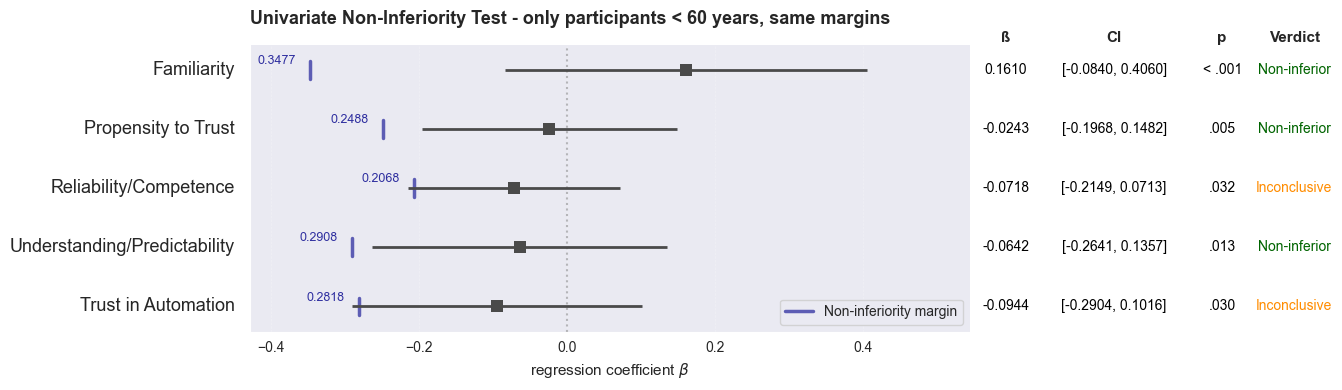

In [8]:
# Plot non-inferiority test
from scripts.viz_utils import plot_noninferiority_test
import matplotlib.pyplot as plt

# coefficients = [regr_res[subscale][regr_res[subscale]['predictor'] == 'group_effect'].iloc[0]['coef'] for subscale in tia_scales]
coefficients = [regr_res[subscale].loc['group_effect']['coef'] for subscale in tia_scales]

#  = [regr_res[subscale][regr_res[subscale]['predictor'] == 'group_effect'].iloc[0]['se'] for subscale in tia_scales]
ses = [regr_res[subscale].loc['group_effect']['se'] for subscale in tia_scales]


fig, ax = plt.subplots(figsize=(13.5, 4))
plot_noninferiority_test(
    effect_size=coefficients,
    sesoi=[ni_margin[subscale] for subscale in tia_scales],
    se=ses,
    alpha=alpha,
    variable_names=tia_scales,
    variable_labels=scales.scale_titles,
    title='Univariate Non-Inferiority Test - only participants < 60 years, same margins',
    xlabel='regression coefficient $\\beta$',
    height_scale=0.5,
    column_title_pos_shift=0,
    estimate_name='ß',
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}univariate_noninferiority_test_YOUNG.png', dpi=150, transparent=False)
plt.show()

In [9]:
# Overview Table: Regression Coefficients for All TiA Subscales
from scripts.stats import format_effect_with_stars

# Create predictor label mapping
predictor_labels = {
    'group_effect': 'Group Effect (Uncertainty vs Control)',
    'age': 'Age',
    'gender': 'Gender',
    'education': 'Education',
    'ai_exp': 'AI Experience',
    'hcsds_c': 'Healthcare Trust - Competence',
    'hcsds_v': 'Healthcare Trust - Values',
    'ati': 'Affinity for Technology',
    'group_effect:age': 'Group x Age',
    'group_effect:gender': 'Group x Gender',
    'group_effect:education': 'Group x Education',
    'group_effect:ai_exp': 'Group x AI Experience',
    'group_effect:hcsds_c': 'Group x Healthcare Trust - Competence',
    'group_effect:hcsds_v': 'Group x Healthcare Trust - Values',
    'group_effect:ati': 'Group x Affinity for Technology'
}

# Load all regression coefficient files
regression_data = {}
for subscale in tia_scales:
    df = pd.read_csv(f'{output_path}{subscale}_regression_coef_YOUNG.csv', index_col=0)
    # Exclude Intercept (no adjusted p-value)
    df = df[df.index != 'Intercept']
    regression_data[subscale] = df

# Build formatted table
results_table = pd.DataFrame(index=predictor_labels.keys())

# Add columns for each TiA subscale with (β) suffix
for subscale in tia_scales:
    df = regression_data[subscale]

    # Create formatted column with coefficient and stars
    formatted_values = []
    for predictor in results_table.index:
        coef = df.loc[predictor, 'coef']
        p_adj = df.loc[predictor, 'p_adj']
        formatted_values.append(format_effect_with_stars(coef, p_adj))


    # Use scale title as column name with (β) suffix
    col_name = scales.scale_titles[subscale] + ' (b)'
    results_table[col_name] = formatted_values

# Apply descriptive labels to row index
results_table.index = [predictor_labels[pred] for pred in results_table.index]

# Display table
print(results_table.to_string())

# Save to CSV
results_table.to_csv(f'{output_path}regression_coefficients_overview_YOUNG.csv')
print(f"\nTable saved to: {output_path}regression_coefficients_overview_YOUNG.csv")

                                      Familiarity (b) Propensity to Trust (b) Reliability/Competence (b) Understanding/Predictability (b) Trust in Automation (b)
Group Effect (Uncertainty vs Control)           0.161                  -0.024                     -0.072                           -0.064                  -0.094
Age                                             0.213                0.255***                   0.223***                            0.032                0.379***
Gender                                         -0.044                   0.043                      0.019                            0.184                   0.133
Education                                       0.075                  -0.046                      0.003                            0.057                   0.043
AI Experience                                   0.058                  0.118*                      0.069                            0.007                 0.167**
Healthcare Trust - Competenc

Figure saved to: ../plots/age/univariate_analysis/coefficient_comparison_full_vs_young.png


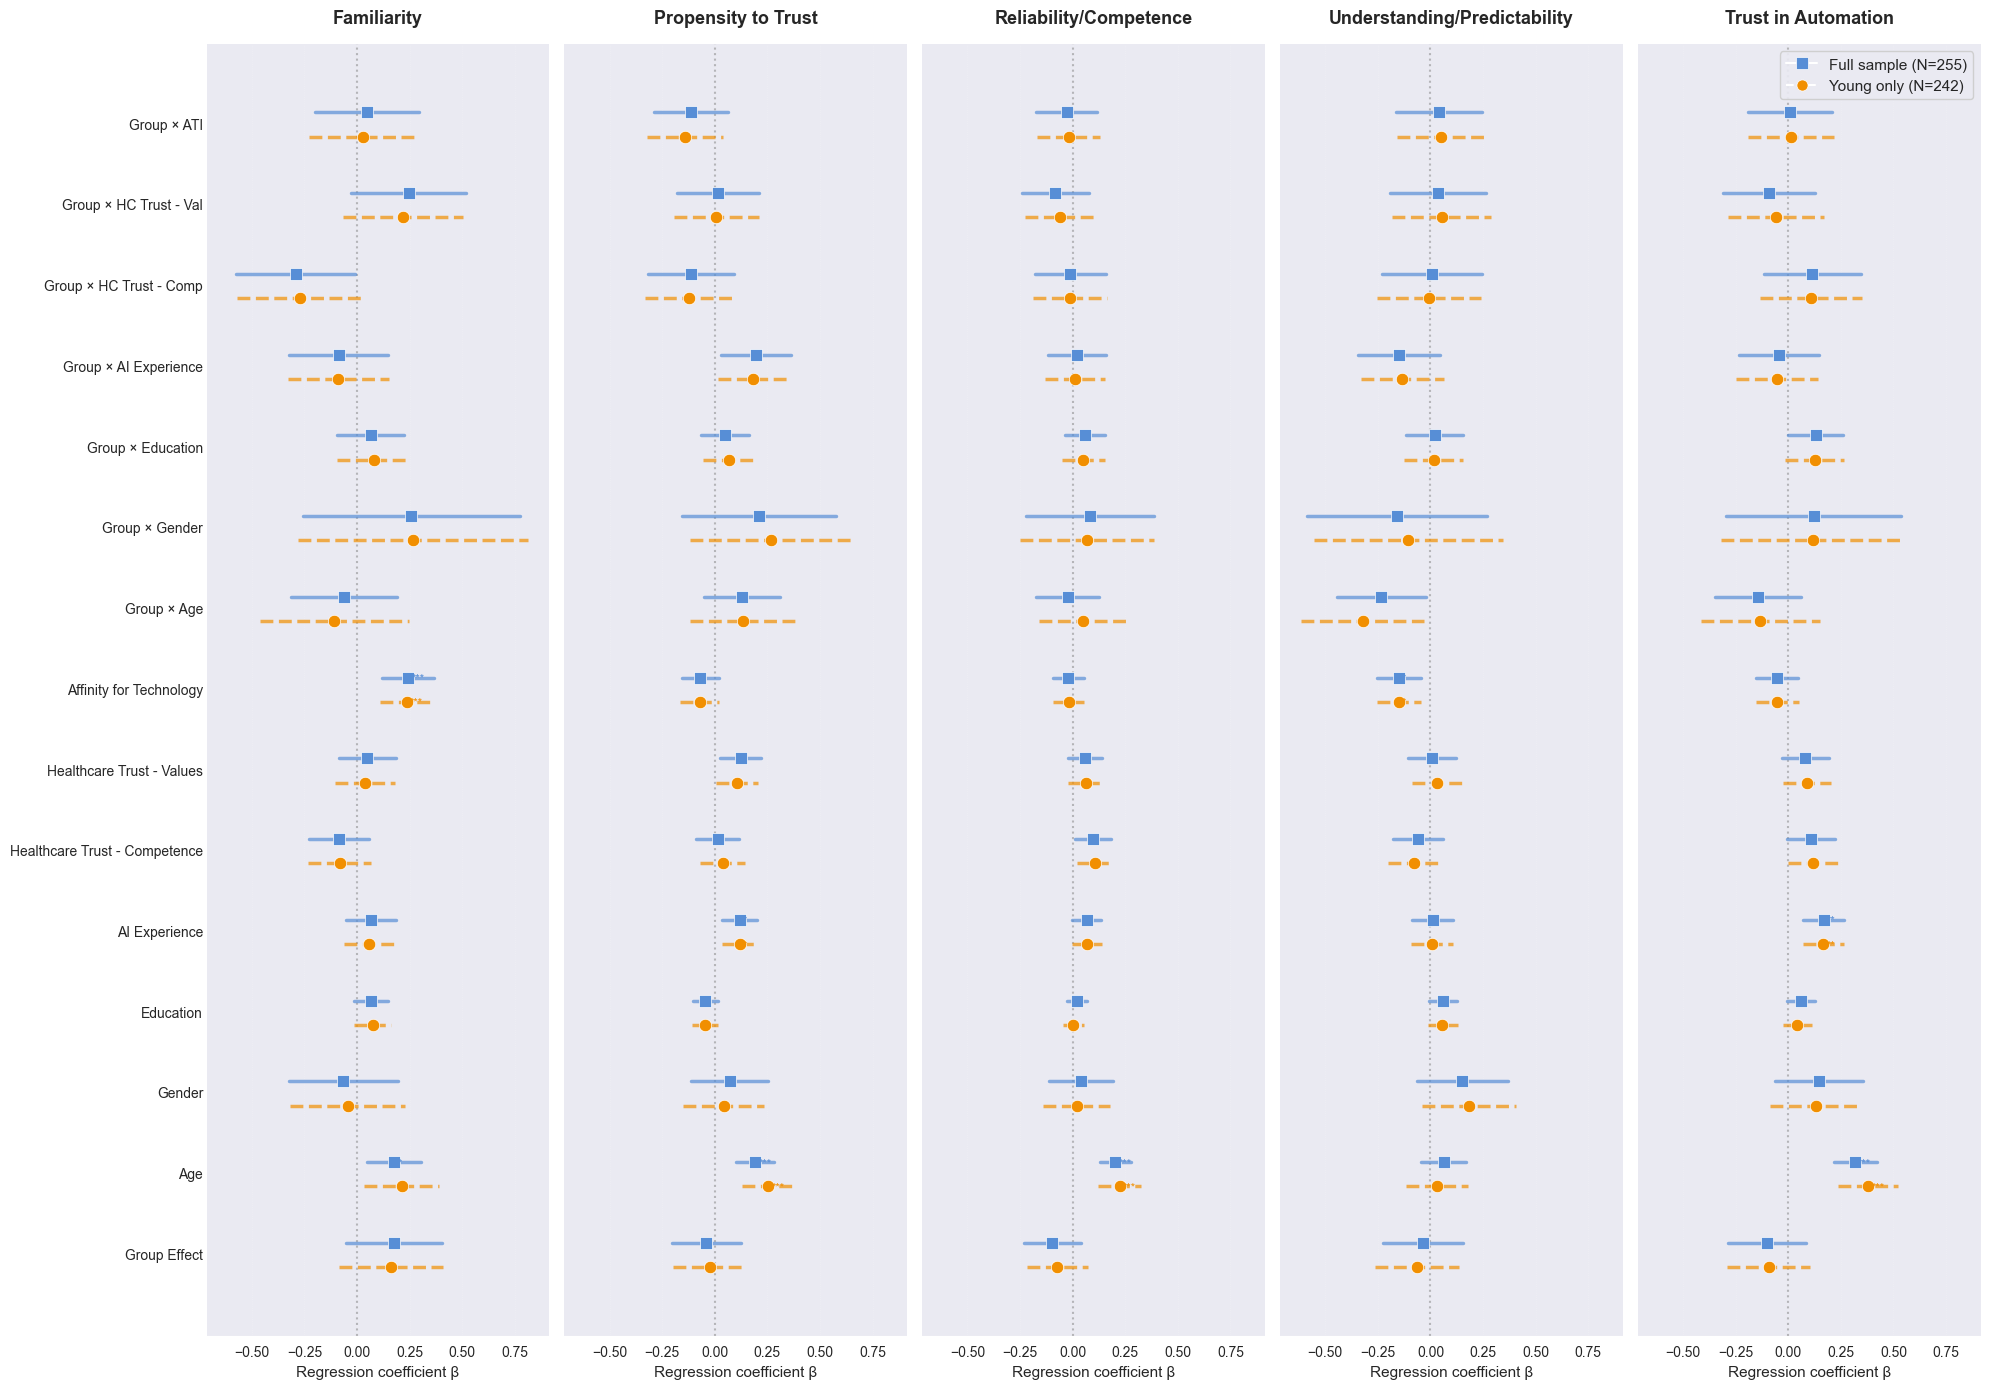

In [10]:
# Visualize coefficient comparison between full and young samples
import importlib
import scripts.viz_utils
importlib.reload(scripts.viz_utils)
from scripts.viz_utils import plot_coefficient_comparison_grid

# Create comparison visualization
fig, axes = plot_coefficient_comparison_grid(
    full_data_path='../output/',
    young_data_path='../output/age/',
    tia_scales=tia_scales,
    scale_titles=scales.scale_titles,
    alpha=alpha,
    figsize=(20, 14),
    save_path=f'{plots_path}coefficient_comparison_full_vs_young.png'
)

plt.show()

In [11]:
# Compare significance changes between full and young samples
import pandas as pd

print("=" * 80)
print("SIGNIFICANCE CHANGES: Full Sample (N=255) vs Young Only (N=242)")
print("=" * 80)
print("\nAnalyzing effects that crossed the α=0.05 threshold between samples...")
print("(Using Holm-corrected p-values)\n")

# Define alpha threshold
alpha_threshold = 0.05

# Predictor label mapping
predictor_labels = {
    'group_effect': 'Group Effect',
    'age': 'Age',
    'gender': 'Gender',
    'education': 'Education',
    'ai_exp': 'AI Experience',
    'hcsds_c': 'Healthcare Trust - Competence',
    'hcsds_v': 'Healthcare Trust - Values',
    'ati': 'Affinity for Technology',
    'group_effect:age': 'Group × Age',
    'group_effect:gender': 'Group × Gender',
    'group_effect:education': 'Group × Education',
    'group_effect:ai_exp': 'Group × AI Experience',
    'group_effect:hcsds_c': 'Group × HC Trust - Competence',
    'group_effect:hcsds_v': 'Group × HC Trust - Values',
    'group_effect:ati': 'Group × ATI'
}

# Track changes across all subscales
changes_summary = []

for subscale in tia_scales:
    # Load data for both samples
    df_full = pd.read_csv(f'../output/{subscale}_regression_coef.csv', index_col=0)
    df_young = pd.read_csv(f'../output/age/{subscale}_regression_coef_YOUNG.csv', index_col=0)
    
    # Remove Intercept
    df_full = df_full[df_full.index != 'Intercept']
    df_young = df_young[df_young.index != 'Intercept']
    
    # Get effects list
    effects = df_full.index.tolist()
    
    # Check each effect for significance changes
    for effect in effects:
        p_full = df_full.loc[effect, 'p_adj']
        p_young = df_young.loc[effect, 'p_adj']
        
        coef_full = df_full.loc[effect, 'coef']
        coef_young = df_young.loc[effect, 'coef']
        
        sig_full = p_full < alpha_threshold
        sig_young = p_young < alpha_threshold
        
        # Check if significance status changed
        if sig_full != sig_young:
            change_type = "Lost significance" if sig_full else "Gained significance"
            
            changes_summary.append({
                'Subscale': scales.scale_titles[subscale],
                'Effect': predictor_labels.get(effect, effect),
                'Change': change_type,
                'β (Full)': coef_full,
                'p_adj (Full)': p_full,
                'β (Young)': coef_young,
                'p_adj (Young)': p_young,
                'Δβ': coef_young - coef_full
            })

# Display results
if len(changes_summary) > 0:
    changes_df = pd.DataFrame(changes_summary)
    
    # Separate into lost and gained significance
    lost_sig = changes_df[changes_df['Change'] == 'Lost significance']
    gained_sig = changes_df[changes_df['Change'] == 'Gained significance']
    
    if len(lost_sig) > 0:
        print(f"\n{'─' * 80}")
        print("EFFECTS THAT LOST SIGNIFICANCE (were p<0.05 in full, now p≥0.05 in young)")
        print(f"{'─' * 80}\n")
        
        for idx, row in lost_sig.iterrows():
            print(f"•  {row['Effect']} → {row['Subscale']}")
            print(f"  Full sample:  β = {row['β (Full)']:>7.3f}, p_adj = {row['p_adj (Full)']:.4f} *")
            print(f"  Young sample: β = {row['β (Young)']:>7.3f}, p_adj = {row['p_adj (Young)']:.4f}")
            print(f"  Change:       Δβ = {row['Δβ']:>7.3f}\n")
    
    if len(gained_sig) > 0:
        print(f"\n{'─' * 80}")
        print("EFFECTS THAT GAINED SIGNIFICANCE (were p≥0.05 in full, now p<0.05 in young)")
        print(f"{'─' * 80}\n")
        
        for idx, row in gained_sig.iterrows():
            print(f"• {row['Subscale']} → {row['Effect']}")
            print(f"  Full sample:  β = {row['β (Full)']:>7.3f}, p_adj = {row['p_adj (Full)']:.4f}")
            print(f"  Young sample: β = {row['β (Young)']:>7.3f}, p_adj = {row['p_adj (Young)']:.4f} *")
            print(f"  Change:       Δβ = {row['Δβ']:>7.3f}\n")
    
    # Summary
    print(f"\n{'═' * 80}")
    print(f"SUMMARY: {len(changes_summary)} effect(s) changed significance status")
    print(f"  - {len(lost_sig)} lost significance")
    print(f"  - {len(gained_sig)} gained significance")
    print(f"{'═' * 80}\n")
    
    # Save to CSV
    changes_df.to_csv(f'{output_path}significance_changes_full_vs_young.csv', index=False)
    print(f"Detailed results saved to: {output_path}significance_changes_full_vs_young.csv")
    
else:
    print("\n✓ No effects changed significance status between samples.")
    print("  All effects that were significant in the full sample remain significant")
    print("  in the young sample, and vice versa.\n")

# Additional analysis: Effects close to the threshold
print(f"\n{'─' * 80}")
print("EFFECTS CLOSE TO SIGNIFICANCE THRESHOLD (0.04 < p_adj < 0.06)")
print(f"{'─' * 80}\n")

close_to_threshold = []
for subscale in tia_scales:
    df_full = pd.read_csv(f'../output/{subscale}_regression_coef.csv', index_col=0)
    df_young = pd.read_csv(f'../output/age/{subscale}_regression_coef_YOUNG.csv', index_col=0)
    
    df_full = df_full[df_full.index != 'Intercept']
    df_young = df_young[df_young.index != 'Intercept']
    
    for effect in df_full.index:
        p_full = df_full.loc[effect, 'p_adj']
        p_young = df_young.loc[effect, 'p_adj']
        
        # Check if either p-value is close to threshold
        if (0.04 < p_full < 0.06) or (0.04 < p_young < 0.06):
            close_to_threshold.append({
                'Subscale': scales.scale_titles[subscale],
                'Effect': predictor_labels.get(effect, effect),
                'p_adj (Full)': p_full,
                'p_adj (Young)': p_young,
                'Status': 'Borderline in both' if (0.04 < p_full < 0.06) and (0.04 < p_young < 0.06) else 'Borderline in one'
            })

if len(close_to_threshold) > 0:
    for item in close_to_threshold:
        print(f"• {item['Effect']} → {item['Subscale']}")
        print(f"  Full:  p_adj = {item['p_adj (Full)']:.4f}")
        print(f"  Young: p_adj = {item['p_adj (Young)']:.4f}\n")
else:
    print("✓ No effects have p-values close to the threshold in either sample.\n")

SIGNIFICANCE CHANGES: Full Sample (N=255) vs Young Only (N=242)

Analyzing effects that crossed the α=0.05 threshold between samples...
(Using Holm-corrected p-values)


────────────────────────────────────────────────────────────────────────────────
EFFECTS THAT LOST SIGNIFICANCE (were p<0.05 in full, now p≥0.05 in young)
────────────────────────────────────────────────────────────────────────────────

•  Age → Familiarity
  Full sample:  β =   0.177, p_adj = 0.0360 *
  Young sample: β =   0.213, p_adj = 0.1140
  Change:       Δβ =   0.036


════════════════════════════════════════════════════════════════════════════════
SUMMARY: 1 effect(s) changed significance status
  - 1 lost significance
  - 0 gained significance
════════════════════════════════════════════════════════════════════════════════

Detailed results saved to: ../output/age/significance_changes_full_vs_young.csv

────────────────────────────────────────────────────────────────────────────────
EFFECTS CLOSE TO SIGNIFICAN